# Building an Architectural Classifier - Notebook 3 - CNNs

The goal in this notebook is to take our pre-processed dataset of interior architectural imagery (containing images of kitchens, bathrooms, bedrooms, living rooms, etc...) and build a machine learning model that can accurately classify when it is looking at an image of a kitchen. This is the third notebook in a series, so I'll omit some of the explanatory notes on the boilerplate from before.
#### Model:
A standard deep neural net showed us that we can potentially classify very well, but suffer from overfitting. We'll use the convolutional network to attempt to reduce the feature count and get over the 'curse of dimensionality'.

In [2]:
import math
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import scipy
import tensorflow.contrib.slim as slim
import time

%matplotlib inline

# Import data and prep

In [3]:
x = np.load('./all_X_shuffled_85_x4686.npy')
y = np.load('./all_Y_shuffled_2_x4686.npy')

print('x: %s | y: %s' % (x.shape, y.shape))

x: (4686, 85, 85, 3) | y: (4686, 2)


### Split the data up into train / test / validation (80% / 10% / 10%)

In [4]:
def split(x, y, test=0.1, train=0.8, validation=0.1):
    assert(len(x) == len(y))
    test_size = int(len(x) * test)
    train_size = int(len(x) * train)
    valid_size = int(len(x) * validation)
    
    x_train = np.array(x[:train_size])
    y_train = np.array(y[:train_size])
    x_val = np.array(x[train_size:train_size + valid_size])
    y_val = np.array(y[train_size:train_size + valid_size])
    x_test = np.array(x[train_size + valid_size:])
    y_test = np.array(y[train_size + valid_size:])
    
    return (x_train, y_train, x_val, y_val, x_test, y_test)

In [5]:
x_train, y_train, x_val, y_val, x_test, y_test = split(x,y)

print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_val:   ', x_val.shape)
print('y_val:   ', y_val.shape)
print('x_test:  ', x_test.shape)
print('y_test:  ', y_test.shape)

x_train:  (3748, 85, 85, 3)
y_train:  (3748, 2)
x_val:    (468, 85, 85, 3)
y_val:    (468, 2)
x_test:   (470, 85, 85, 3)
y_test:   (470, 2)


### Balancing
The numpy files we just imported were built in a seperate notebook, and they have already been shuffled randomly and balanced across classes, but lets check just to be sure, and to establish a baseline error:

In [6]:
print('Training balance:   ', np.sum(y_train, axis=0)[1] / len(y_train))
print('Validation balance: ', np.sum(y_val, axis=0)[1] / len(y_val))
print('Testing balance:    ', np.sum(y_test, axis=0)[1] / len(y_test))

Training balance:    0.482924226254
Validation balance:  0.480769230769
Testing balance:     0.436170212766


Lets view one of the images and labels as well:

Label:  [0 1]


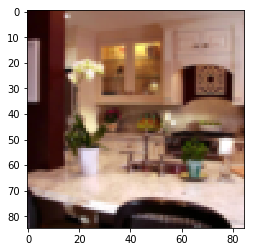

In [7]:
plt.imshow(x_train[1])
print('Label: ', y_train[1])

# Build the model

In [8]:
learning_rate = 0.00005

In [9]:
ops.reset_default_graph()

# I'll feed in the hyper-parameters as placeholders
batch_p = tf.placeholder(tf.int32, name='batch_size')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# The data examples will load much faster if queue runners are used to 
# feed the GPU. This sets up a queue served by 10 threads that will feed 
# randomly shuffled batches of data (allowing mini-batch gradient descent)
with tf.variable_scope('queue'):
    # Queue the input data
    q = tf.FIFOQueue(capacity=3748, dtypes=[tf.float32, tf.int32], shapes=[[85,85,3],[2]])
    enqueue_op = q.enqueue_many([x_train, y_train])
    dq_x, dq_y = q.dequeue()
    input_x, y_truth = tf.train.shuffle_batch([dq_x, dq_y], batch_size=batch_p, capacity=3748, min_after_dequeue=512)

    numberOfThreads = 10
    qr = tf.train.QueueRunner(q, [enqueue_op] * numberOfThreads)
    tf.train.add_queue_runner(qr)
    
### Model architecture
x_image = tf.reshape(input_x, [-1, 85, 85, 3])

# Layer one convolution
conv_1 = slim.conv2d(x_image, 8, [3,3], scope='layer_one')
# Layer two max pool
pool_1 = slim.max_pool2d(conv_1, [2,2], scope='layer_two')
# Layer three convolution
conv_2 = slim.conv2d(pool_1, 16, [3,3], scope='layer_three')
# Layer four max pool
pool_2 = slim.max_pool2d(conv_2, [2,2], scope='layer_four')

# Layer five fully connected w/ dropout
fc_1 = slim.fully_connected(slim.flatten(pool_2), 768, scope='layer_fc1')
fc_1 = slim.dropout(fc_1, keep_prob)

linear_outputs = slim.fully_connected(fc_1, 2, activation_fn=None, scope='output_layer')
###
    
with tf.variable_scope('training'):
    losses = tf.nn.softmax_cross_entropy_with_logits(logits = linear_outputs, labels = y_truth)
    cross_entropy = tf.reduce_mean(losses)
    adam = tf.train.AdamOptimizer(learning_rate)
    train_step = adam.minimize(cross_entropy, name='optimizer')
    
with tf.variable_scope('accuracy'):
    predictions = tf.argmax(linear_outputs, axis=1)
    truths = tf.argmax(y_truth, axis=1)
    correct_predictions = tf.equal(predictions, truths)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

## Start a session and spin up the queue runners

In [10]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

merged = tf.summary.merge_all()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=sess)
train_writer = tf.summary.FileWriter('logs/conv_softmax/train', sess.graph)
valid_writer = tf.summary.FileWriter('logs/conv_softmax/valid', sess.graph)

## Run training

In [11]:
hyper_minibatch_size = 128
hyper_keep_prob = 0.25

start_time = time.time()
for epoch in range(750):
    if epoch % 10 == 0:
        train_summary, train_acc = sess.run([merged, accuracy], {x_image: x_train, y_truth: y_train, batch_p: len(x_train), keep_prob: 1})
        valid_summary, valid_acc = sess.run([merged, accuracy], {x_image: x_val, y_truth: y_val, batch_p: len(x_val), keep_prob:1})
        train_writer.add_summary(train_summary, epoch)
        valid_writer.add_summary(valid_summary, epoch)
        if epoch != 0: 
            time_taken = round((time.time() - start_time) / epoch, 3)
            print('Epoch %s | Time per epoch: %s | Train Accuracy: %s | Validation Accuracy: %s' % (epoch, time_taken, train_acc, valid_acc))

    for batch in range(int(x_train.shape[0] / hyper_minibatch_size)):
        sess.run([train_step], {batch_p: hyper_minibatch_size, keep_prob: hyper_keep_prob})

print('Time Taken: ', time.time() - start_time)

Epoch 10 | Time per epoch: 1.662 | Train Accuracy: 0.625133 | Validation Accuracy: 0.617521
Epoch 20 | Time per epoch: 1.511 | Train Accuracy: 0.660886 | Validation Accuracy: 0.57265
Epoch 30 | Time per epoch: 1.463 | Train Accuracy: 0.689168 | Validation Accuracy: 0.598291
Epoch 40 | Time per epoch: 1.436 | Train Accuracy: 0.695571 | Validation Accuracy: 0.602564
Epoch 50 | Time per epoch: 1.419 | Train Accuracy: 0.728655 | Validation Accuracy: 0.666667

... Edited for length in this gist, see tensorboard below for full training details...

Epoch 700 | Time per epoch: 1.358 | Train Accuracy: 1.0 | Validation Accuracy: 0.762821
Epoch 710 | Time per epoch: 1.358 | Train Accuracy: 1.0 | Validation Accuracy: 0.758547
Epoch 720 | Time per epoch: 1.358 | Train Accuracy: 1.0 | Validation Accuracy: 0.760684
Epoch 730 | Time per epoch: 1.358 | Train Accuracy: 1.0 | Validation Accuracy: 0.754274
Epoch 740 | Time per epoch: 1.358 | Train Accuracy: 1.0 | Validation Accuracy: 0.769231
Time Taken: 

### Even better! :)
[You can view the tensorboard summary here.](https://raw.githubusercontent.com/McCulloughRT/machine-learning/master/cnn_training.png) Purple is the validation accuracy and blue training.

We're starting to solve the overfitting error, and you can also see the model is converging much faster, as a result of the smaller but more useful feature map size that the classifier layer is acting on.
#### Lets check the models accuracy against the training set

In [12]:
sess.run([accuracy], {x_image: x_test, y_truth: y_test, batch_p: len(x_test), keep_prob: 1.0})

[0.76170206]